# Operation Research II

## Phase II Project

### MIP via Pyomo

In [129]:
import pandas as pd
import pyomo.environ as pyo

# Read the Excel file
df = pd.read_excel("Time Data.xlsx", index_col=0)

# Convert DataFrame to dictionary
p = {}
for i, row in df.iterrows():
    for j in df.columns:
        p[(int(i.split()[-1]), j.split()[-1])] = row[j]

d = {1: 4, 2: 10, 3: 5, 4: 20, 5: 0}

M = 1000000
# Define the model
model = pyo.ConcreteModel()

# Define sets
model.I = pyo.Set(initialize=[1, 2, 3, 4, 5])
model.J = pyo.Set(initialize=['A', 'B', 'C'])

# Define parameters
model.p = pyo.Param(model.I, model.J, initialize=p, default=0)
model.d = pyo.Param(model.I, initialize=d)

# Define variables
model.x = pyo.Var(model.I, model.J, model.J, within=pyo.Binary)
model.t = pyo.Var(model.I, model.J, within=pyo.NonNegativeReals)
model.C = pyo.Var(model.J, within=pyo.NonNegativeReals)
model.Z = pyo.Var(within=pyo.NonNegativeReals)

# Objective function
model.obj = pyo.Objective(expr=model.Z, sense=pyo.minimize)

# Constraints

# 1. Makespan definition
def makespan_rule(model, j):
    return model.Z >= model.C[j]
model.makespan = pyo.Constraint(model.J, rule=makespan_rule)

# 2&3. Completion Constraints
model.CA_constraint = pyo.Constraint(expr=model.C['A'] <= 60)
model.CB_CC_constraint = pyo.Constraint(expr=model.C['B'] >= model.C['C'] + 15)

# 4. Completion time constraints
def completion_time_rule(model, i, j):
    if (i, j) in model.p:
        return model.t[i, j] + model.p[i, j] <= model.C[j]
    return pyo.Constraint.Skip
model.completion_time = pyo.Constraint(model.I, model.J, rule=completion_time_rule)

# Constraint 5: Sequencing constraints for different machines and products
def sequencing_rule(model, i, j, k):
    if j != k:
        return model.t[i, k] + model.p[i, k] + model.d[i] - M * (1 - model.x[i, k, j]) <= model.t[i, j]
    return pyo.Constraint.Skip
model.sequencing = pyo.Constraint(model.I, model.J, model.J, rule=sequencing_rule)


'''
# Constraint 6: Binary constraints for x variables
def binary_x_rule(model, i, j, k):
    if j != k:
        return model.x[i, j, k] + model.x[i, k, j] == 1
    return pyo.Constraint.Skip
model.binary_x = pyo.Constraint(model.I, model.J, model.J, rule=binary_x_rule)
'''

def binary_x_rule1(model, j, k):
    for j in ['A', 'B']:
      for k in ['A', 'B'] :
        if j != k:
          return model.x[1, j, k] + model.x[1, k, j] == 1
    return pyo.Constraint.Skip
model.binary_x1 = pyo.Constraint(model.J, model.J, rule=binary_x_rule1)

def binary_x_rule2(model, j, k):
    if j != k:
        return model.x[2, j, k] + model.x[2, k, j] == 1
    return pyo.Constraint.Skip
model.binary_x2 = pyo.Constraint(model.J, model.J, rule=binary_x_rule2)

def binary_x_rule3(model, j, k):
    for j in ['A', 'C']:
      for k in ['A', 'C'] :
        if j != k:
          return model.x[3, j, k] + model.x[3, k, j] == 1
    return pyo.Constraint.Skip
model.binary_x3 = pyo.Constraint(model.J, model.J, rule=binary_x_rule3)

def binary_x_rule4(model, j, k):
    for j in ['A', 'B']:
      for k in ['A', 'B'] :
        if j != k:
          return model.x[4, j, k] + model.x[4, k, j] == 1
    return pyo.Constraint.Skip
model.binary_x4 = pyo.Constraint(model.J, model.J, rule=binary_x_rule4)

def binary_x_rule5(model, j, k):
    for j in ['C', 'B']:
      for k in ['C', 'B'] :
        if j != k:
          return model.x[5, j, k] + model.x[5, k, j] == 1
    return pyo.Constraint.Skip
model.binary_x5 = pyo.Constraint(model.J, model.J, rule=binary_x_rule5)

# 7. Constraint
model.A1_constraint = pyo.Constraint(expr= model.t[1, 'A'] + model.p[1, 'A'] <= model.t[2, 'A'])
model.A2_constraint = pyo.Constraint(expr= model.t[2, 'A'] + model.p[2, 'A'] <= model.t[3, 'A'])
model.A3_constraint = pyo.Constraint(expr= model.t[3, 'A'] + model.p[3, 'A'] <= model.t[4, 'A'])

# 8. Constraint
model.B1_constraint = pyo.Constraint(expr= model.t[1, 'B'] + model.p[1, 'B'] <= model.t[2, 'B'])
model.B2_constraint = pyo.Constraint(expr= model.t[2, 'B'] + model.p[2, 'B'] <= model.t[4, 'B'])
model.B3_constraint = pyo.Constraint(expr= model.t[4, 'B'] + model.p[4, 'B'] <= model.t[5, 'B'])

# 9. Constraint
model.C1_constraint = pyo.Constraint(expr= model.t[2, 'C'] + model.p[2, 'C'] <= model.t[3, 'C'])
model.C2_constraint = pyo.Constraint(expr= model.t[3, 'C'] + model.p[3, 'C'] <= model.t[5, 'C'])

# 10. Constraints
model.t5A_constraint = pyo.Constraint(expr=model.t[5, 'A'] == 0)
model.t3B_constraint = pyo.Constraint(expr=model.t[3, 'B'] == 0)
model.t1C_constraint = pyo.Constraint(expr=model.t[1, 'C'] == 0)
model.t4C_constraint = pyo.Constraint(expr=model.t[4, 'C'] == 0)


# Solve the model
solver = pyo.SolverFactory('cplex_direct')
results = solver.solve(model, tee=True)

# Print the results
model.display()


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 3 times.
MIP Presolve eliminated 78 rows and 46 columns.
MIP Presolve modified 28 coefficients.
Aggregator did 7 substitutions.
Reduced MIP has 19 rows, 11 columns, and 44 nonzeros.
Reduced MIP has 3 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.17 ticks)
Found incumbent of value 1000059.000000 after 0.00 sec. (0.20 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 1 rows and 0 columns.
MIP Presolve modified 6 coefficients.
Reduced MIP has 18 rows, 11 columns, and 42 nonzeros.
Reduced MIP has 3 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Clique table members: 1.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 2 

### MIP via GurobiPy

In [130]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

# Read the Excel file
df = pd.read_excel("Time Data.xlsx", index_col=0)

# Convert DataFrame to dictionary
p = {}
for i, row in df.iterrows():
    for j in df.columns:
        p[(int(i.split()[-1]), j.split()[-1])] = row[j]

d = {1: 4, 2: 10, 3: 5, 4: 20, 5: 0}

M = 1000000  # A large constant for constraints

# Define sets
I = [1, 2, 3, 4, 5]
J = ['A', 'B', 'C']

# Initialize Gurobi model
model = gp.Model("scheduling")

# Define variables
x = model.addVars(I, J, J, vtype=GRB.BINARY, name="x")
t = model.addVars(I, J, vtype=GRB.CONTINUOUS, lb=0.0, name="t")
C = model.addVars(J, vtype=GRB.CONTINUOUS, lb=0.0, name="C")
Z = model.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="Z")

# Objective function
model.setObjective(Z, GRB.MINIMIZE)

# Constraints

# 1. Makespan definition
model.addConstrs((Z >= C[j] for j in J), name="makespan")

# 2&3. Completion Constraints
model.addConstr(C['A'] <= 60, name="CA_constraint")
model.addConstr(C['B'] >= C['C'] + 15, name="CB_CC_constraint")

# 4. Completion time constraints
model.addConstrs((t[i, j] + p[i, j] <= C[j] for i in I for j in J), name="completion_time")

# 5. Sequencing constraints for different machines and products
model.addConstrs((t[i, k] + p[i, k] + d[i] - M * (1 - x[i, k, j]) <= t[i, j]
                  for i in I for j in J for k in J if j != k), name="sequencing")

# Binary x constraints
model.addConstrs((x[1, j, k] + x[1, k, j] == 1 for j in ['A', 'B'] for k in ['A', 'B'] if j != k), name="binary_x1")
model.addConstrs((x[2, j, k] + x[2, k, j] == 1 for j in J for k in J if j != k), name="binary_x2")
model.addConstrs((x[3, j, k] + x[3, k, j] == 1 for j in ['A', 'C'] for k in ['A', 'C'] if j != k), name="binary_x3")
model.addConstrs((x[4, j, k] + x[4, k, j] == 1 for j in ['A', 'B'] for k in ['A', 'B'] if j != k), name="binary_x4")
model.addConstrs((x[5, j, k] + x[5, k, j] == 1 for j in ['C', 'B'] for k in ['C', 'B'] if j != k), name="binary_x5")

# 7. Constraints
model.addConstr(t[1, 'A'] + p[1, 'A'] <= t[2, 'A'], name="A1_constraint")
model.addConstr(t[2, 'A'] + p[2, 'A'] <= t[3, 'A'], name="A2_constraint")
model.addConstr(t[3, 'A'] + p[3, 'A'] <= t[4, 'A'], name="A3_constraint")

# 8. Constraints
model.addConstr(t[1, 'B'] + p[1, 'B'] <= t[2, 'B'], name="B1_constraint")
model.addConstr(t[2, 'B'] + p[2, 'B'] <= t[4, 'B'], name="B2_constraint")
model.addConstr(t[4, 'B'] + p[4, 'B'] <= t[5, 'B'], name="B3_constraint")

# 9. Constraints
model.addConstr(t[2, 'C'] + p[2, 'C'] <= t[3, 'C'], name="C1_constraint")
model.addConstr(t[3, 'C'] + p[3, 'C'] <= t[5, 'C'], name="C2_constraint")

# 10. Constraints
model.addConstr(t[5, 'A'] == 0, name="t5A_constraint")
model.addConstr(t[3, 'B'] == 0, name="t3B_constraint")
model.addConstr(t[1, 'C'] == 0, name="t1C_constraint")
model.addConstr(t[4, 'C'] == 0, name="t4C_constraint")

# Optimize the model
model.optimize()

# Print the results
if model.Status == GRB.OPTIMAL:
    for v in model.getVars():
        print(f'{v.varName}: {v.x}')
    print(f'Objective Value: {model.objVal}')
else:
    print("No optimal solution found")


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 76 rows, 64 columns and 177 nonzeros
Model fingerprint: 0x57c4c881
Variable types: 19 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 106.0000000
Presolve removed 58 rows and 53 columns
Presolve time: 0.00s
Presolved: 18 rows, 11 columns, 42 nonzeros
Found heuristic solution: objective 99.0000000
Variable types: 8 continuous, 3 integer (3 binary)

Root relaxation: objective 9.600000e+01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

####  Saving the results in a DataFrame

In [131]:
# Extract variable values
results = {}
for v in model.getVars():
    results[v.varName] = v.x

# Create a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# Print the DataFrame
print(results_df)


          Value
x[1,A,A]    0.0
x[1,A,B]    1.0
x[1,A,C]    0.0
x[1,B,A]    0.0
x[1,B,B]    0.0
...         ...
t[5,C]     75.0
C[A]       60.0
C[B]       96.0
C[C]       81.0
Z          96.0

[64 rows x 1 columns]


In [132]:
# Reset the index to create a new column with the original index values
results_df.reset_index(inplace=True)

# Rename the columns
results_df.rename(columns={'index': 'Variable', 'Value': 'Value'}, inplace=True)

# Display the updated DataFrame
print(results_df)


    Variable  Value
0   x[1,A,A]    0.0
1   x[1,A,B]    1.0
2   x[1,A,C]    0.0
3   x[1,B,A]    0.0
4   x[1,B,B]    0.0
..       ...    ...
59    t[5,C]   75.0
60      C[A]   60.0
61      C[B]   96.0
62      C[C]   81.0
63         Z   96.0

[64 rows x 2 columns]


In [133]:
# Filter rows containing 't[i, j]'
filtered_df = results_df[results_df['Variable'].str.contains('t\[\d+,\w+\]')]

# Reset the index
filtered_df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(filtered_df)


   Variable  Value
0    t[1,A]    0.0
1    t[1,B]   14.0
2    t[1,C]    0.0
3    t[2,A]   10.0
4    t[2,B]   45.0
5    t[2,C]   26.0
6    t[3,A]   16.0
7    t[3,B]    0.0
8    t[3,C]   61.0
9    t[4,A]   28.0
10   t[4,B]   70.0
11   t[4,C]    0.0
12   t[5,A]    0.0
13   t[5,B]   89.0
14   t[5,C]   75.0


In [134]:
# Extract the relevant information from the 'Variable' column
filtered_df['Machine'] = filtered_df['Variable'].str.extract(r't\[(\d+),\w+\]')[0].astype(int)
filtered_df['Product'] = filtered_df['Variable'].str.extract(r't\[\d+,(\w+)\]')[0]
filtered_df.rename(columns={'Value': 'Start Time'}, inplace=True)

# Create a new DataFrame with the extracted columns
new_df = filtered_df[['Machine', 'Product', 'Start Time']]

# Display the new DataFrame
print(new_df)

    Machine Product  Start Time
0         1       A         0.0
1         1       B        14.0
2         1       C         0.0
3         2       A        10.0
4         2       B        45.0
5         2       C        26.0
6         3       A        16.0
7         3       B         0.0
8         3       C        61.0
9         4       A        28.0
10        4       B        70.0
11        4       C         0.0
12        5       A         0.0
13        5       B        89.0
14        5       C        75.0


<ipython-input-134-ce4186bd2f20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Machine'] = filtered_df['Variable'].str.extract(r't\[(\d+),\w+\]')[0].astype(int)
<ipython-input-134-ce4186bd2f20>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Product'] = filtered_df['Variable'].str.extract(r't\[\d+,(\w+)\]')[0]
<ipython-input-134-ce4186bd2f20>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

In [135]:
# Read the Excel file again
time_data = pd.read_excel("Time Data.xlsx", index_col=0)

print(time_data)


                 Product A  Product B  Product C
machine/product                                 
Machine 1               10          8          0
Machine 2                6          9          9
Machine 3               12          0         14
Machine 4               22         19          0
Machine 5                0          7          6


In [136]:
# Adding a new column for Finish Time
new_df["Finish Time"] = 0.0

# Calculating the Finish Time
for index, row in new_df.iterrows():
    machine = row["Machine"]
    product = row["Product"]
    start_time = row["Start Time"]

    # Get the processing time from time_data
    processing_time = time_data.loc[f"Machine {machine}", f"Product {product}"]

    # Calculate the finish time
    finish_time = start_time + processing_time

    # Update the Finish Time in the dataframe
    new_df.at[index, "Finish Time"] = finish_time

# Display the resulting dataframe
print(new_df)


    Machine Product  Start Time  Finish Time
0         1       A         0.0         10.0
1         1       B        14.0         22.0
2         1       C         0.0          0.0
3         2       A        10.0         16.0
4         2       B        45.0         54.0
5         2       C        26.0         35.0
6         3       A        16.0         28.0
7         3       B         0.0          0.0
8         3       C        61.0         75.0
9         4       A        28.0         50.0
10        4       B        70.0         89.0
11        4       C         0.0          0.0
12        5       A         0.0          0.0
13        5       B        89.0         96.0
14        5       C        75.0         81.0


#### the Gantt chart

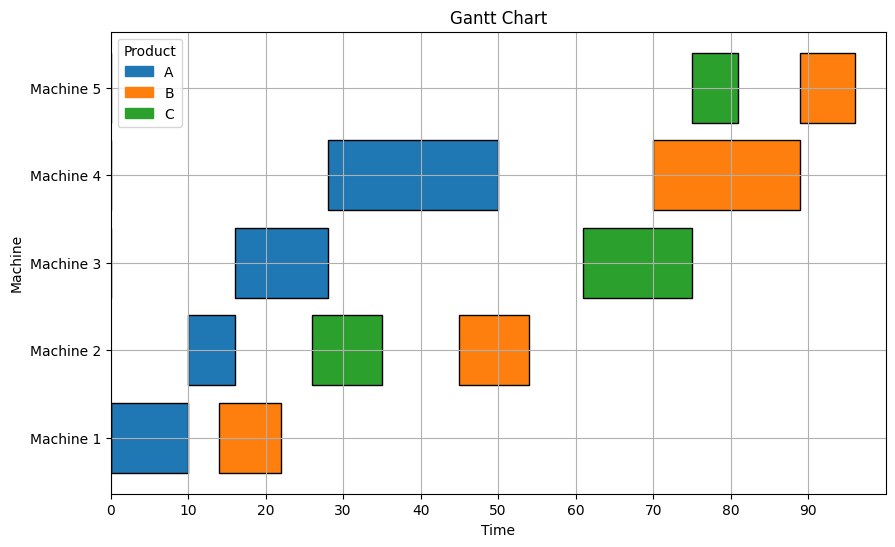

In [141]:
import matplotlib.pyplot as plt

# Create the Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Color mapping for products
colors = {
    "A": "tab:blue",
    "B": "tab:orange",
    "C": "tab:green"
}

# Plot each task
for idx, row in new_df.iterrows():
    start = row["Start Time"]
    end = row["Finish Time"]
    machine = row["Machine"]
    product = row["Product"]
    ax.barh(machine, end - start, left=start, color=colors[product], edgecolor='black')

# Adding labels and formatting
ax.set_xlabel('Time')
ax.set_ylabel('Machine')
ax.set_title('Gantt Chart')
ax.set_xticks(range(0, 100, 10))
ax.set_xlim(0, 100)
ax.set_yticks(new_df["Machine"].unique())
ax.set_yticklabels([f"Machine {int(m)}" for m in new_df["Machine"].unique()])
ax.grid(True)

# Creating a legend
handles = [plt.Rectangle((0,0),1,1, color=colors[product]) for product in colors]
labels = colors.keys()
ax.legend(handles, labels, title="Product")

plt.show()


#### Sensitivity Analysis

In [142]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

def optimize_model(S1, S2, S3, max_time_A, min_delay_B):
    # Read the Excel file
    df = pd.read_excel("Time Data.xlsx", index_col=0)

    # Convert DataFrame to dictionary
    p = {}
    for i, row in df.iterrows():
        for j in df.columns:
            p[(int(i.split()[-1]), j.split()[-1])] = row[j]

    # Update specific values as per the parameters
    p[(2, 'B')] = S1
    p[(4, 'A')] = S2
    p[(5, 'C')] = S3

    d = {1: 4, 2: min_delay_B, 3: 5, 4: 20, 5: 0}
    M = 1000000  # A large constant for constraints

    # Define sets
    I = [1, 2, 3, 4, 5]
    J = ['A', 'B', 'C']

    # Initialize Gurobi model
    model = gp.Model("scheduling")

    # Define variables
    x = model.addVars(I, J, J, vtype=GRB.BINARY, name="x")
    t = model.addVars(I, J, vtype=GRB.CONTINUOUS, lb=0.0, name="t")
    C = model.addVars(J, vtype=GRB.CONTINUOUS, lb=0.0, name="C")
    Z = model.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="Z")

    # Objective function
    model.setObjective(Z, GRB.MINIMIZE)

    # Constraints
    # 1. Makespan definition
    model.addConstrs((Z >= C[j] for j in J), name="makespan")

    # 2 & 3. Completion Constraints
    model.addConstr(C['A'] <= max_time_A, name="CA_constraint")
    model.addConstr(C['B'] >= C['C'] + 15, name="CB_CC_constraint")

    # 4. Completion time constraints
    model.addConstrs((t[i, j] + p[i, j] <= C[j] for i in I for j in J), name="completion_time")

    # 5. Sequencing constraints for different machines and products
    model.addConstrs((t[i, k] + p[i, k] + d[i] - M * (1 - x[i, k, j]) <= t[i, j]
                      for i in I for j in J for k in J if j != k), name="sequencing")

    # Binary x constraints
    model.addConstrs((x[1, j, k] + x[1, k, j] == 1 for j in ['A', 'B'] for k in ['A', 'B'] if j != k), name="binary_x1")
    model.addConstrs((x[2, j, k] + x[2, k, j] == 1 for j in J for k in J if j != k), name="binary_x2")
    model.addConstrs((x[3, j, k] + x[3, k, j] == 1 for j in ['A', 'C'] for k in ['A', 'C'] if j != k), name="binary_x3")
    model.addConstrs((x[4, j, k] + x[4, k, j] == 1 for j in ['A', 'B'] for k in ['A', 'B'] if j != k), name="binary_x4")
    model.addConstrs((x[5, j, k] + x[5, k, j] == 1 for j in ['C', 'B'] for k in ['C', 'B'] if j != k), name="binary_x5")

    # 7. Constraints
    model.addConstr(t[1, 'A'] + p[1, 'A'] <= t[2, 'A'], name="A1_constraint")
    model.addConstr(t[2, 'A'] + p[2, 'A'] <= t[3, 'A'], name="A2_constraint")
    model.addConstr(t[3, 'A'] + p[3, 'A'] <= t[4, 'A'], name="A3_constraint")

    # 8. Constraints
    model.addConstr(t[1, 'B'] + p[1, 'B'] <= t[2, 'B'], name="B1_constraint")
    model.addConstr(t[2, 'B'] + p[2, 'B'] <= t[4, 'B'], name="B2_constraint")
    model.addConstr(t[4, 'B'] + p[4, 'B'] <= t[5, 'B'], name="B3_constraint")

    # 9. Constraints
    model.addConstr(t[2, 'C'] + p[2, 'C'] <= t[3, 'C'], name="C1_constraint")
    model.addConstr(t[3, 'C'] + p[3, 'C'] <= t[5, 'C'], name="C2_constraint")

    # 10. Constraints
    model.addConstr(t[5, 'A'] == 0, name="t5A_constraint")
    model.addConstr(t[3, 'B'] == 0, name="t3B_constraint")
    model.addConstr(t[1, 'C'] == 0, name="t1C_constraint")
    model.addConstr(t[4, 'C'] == 0, name="t4C_constraint")

    # Optimize the model
    model.optimize()

    results = {}
    if model.Status == GRB.OPTIMAL:
        results['variables'] = {v.varName: v.x for v in model.getVars()}
        results['objective'] = model.objVal
    else:
        results['status'] = 'No optimal solution found'

    return results

def sensitivity_analysis():
    # Original values
    S1 = 9
    S2 = 22
    S3 = 6
    max_time_A = 60
    min_delay_B = 10

    param_ranges = {
        'S1': range(1, 21),
        'S2': range(1, 16),
        'S3': range(1, 19),
        'max_time_A': range(50, 81),
        'min_delay_B': range(3, 16),
    }

    # Store the results of the original parameters
    original_results = optimize_model(S1, S2, S3, max_time_A, min_delay_B)
    sensitivity_results = {'original': original_results}

    # Perform sensitivity analysis for each parameter
    for param, values in param_ranges.items():
        for value in values:
            if param == 'S1':
                result = optimize_model(value, S2, S3, max_time_A, min_delay_B)
            elif param == 'S2':
                result = optimize_model(S1, value, S3, max_time_A, min_delay_B)
            elif param == 'S3':
                result = optimize_model(S1, S2, value, max_time_A, min_delay_B)
            elif param == 'max_time_A':
                result = optimize_model(S1, S2, S3, value, min_delay_B)
            elif param == 'min_delay_B':
                result = optimize_model(S1, S2, S3, max_time_A, value)
            sensitivity_results[f"{param}_{value}"] = result

    return sensitivity_results

# Run sensitivity analysis
results = sensitivity_analysis()

# Print or save results as needed
for key, result in results.items():
    if 'objective' in result:
        print(f"{key}: Objective Value = {result['objective']}")
    else:
        print(f"{key}: {result['status']}")

# Optional: Save results to a file
import json
with open('sensitivity_analysis_results.json', 'w') as f:
    json.dump(results, f, indent=4)


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 76 rows, 64 columns and 177 nonzeros
Model fingerprint: 0x57c4c881
Variable types: 19 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 106.0000000
Presolve removed 58 rows and 53 columns
Presolve time: 0.00s
Presolved: 18 rows, 11 columns, 42 nonzeros
Found heuristic solution: objective 99.0000000
Variable types: 8 continuous, 3 integer (3 binary)

Root relaxation: objective 9.600000e+01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

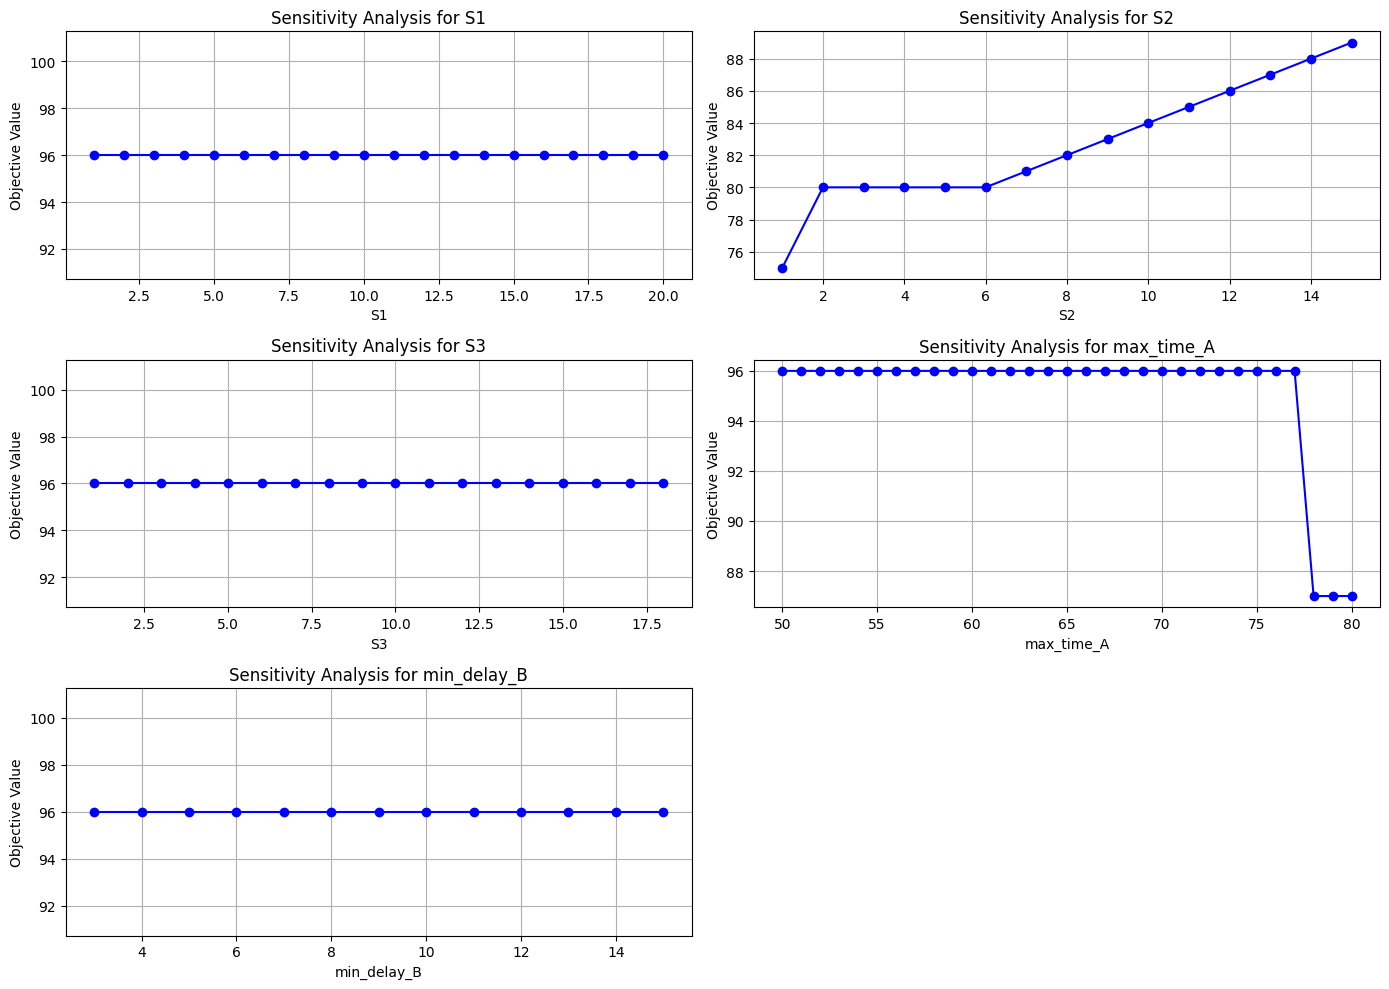

In [143]:
# Extract results for plotting
def extract_plot_data(results, param_name, param_range):
    plot_data = []
    for value in param_range:
        key = f"{param_name}_{value}"
        if 'objective' in results[key]:
            plot_data.append((value, results[key]['objective']))
        else:
            plot_data.append((value, None))  # Handle cases where no optimal solution is found
    return plot_data

# Plot results
def plot_sensitivity_analysis(results):
    param_ranges = {
        'S1': range(1, 21),
        'S2': range(1, 16),
        'S3': range(1, 19),
        'max_time_A': range(50, 81),
        'min_delay_B': range(3, 16),
    }

    plt.figure(figsize=(14, 10))

    for i, (param, param_range) in enumerate(param_ranges.items(), start=1):
        plt.subplot(3, 2, i)
        plot_data = extract_plot_data(results, param, param_range)
        x, y = zip(*plot_data)
        plt.plot(x, y, marker='o', linestyle='-', color='b')
        plt.xlabel(param)
        plt.ylabel('Objective Value')
        plt.title(f'Sensitivity Analysis for {param}')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run and plot the sensitivity analysis
plot_sensitivity_analysis(results)